<a href="https://colab.research.google.com/github/RivadineiraVargas/Estimaci-n-Homografica/blob/main/Estimacion_Homografica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Numero final de iteraciones ejecutadas: 5
Número máximo de inliers encontrados: 5


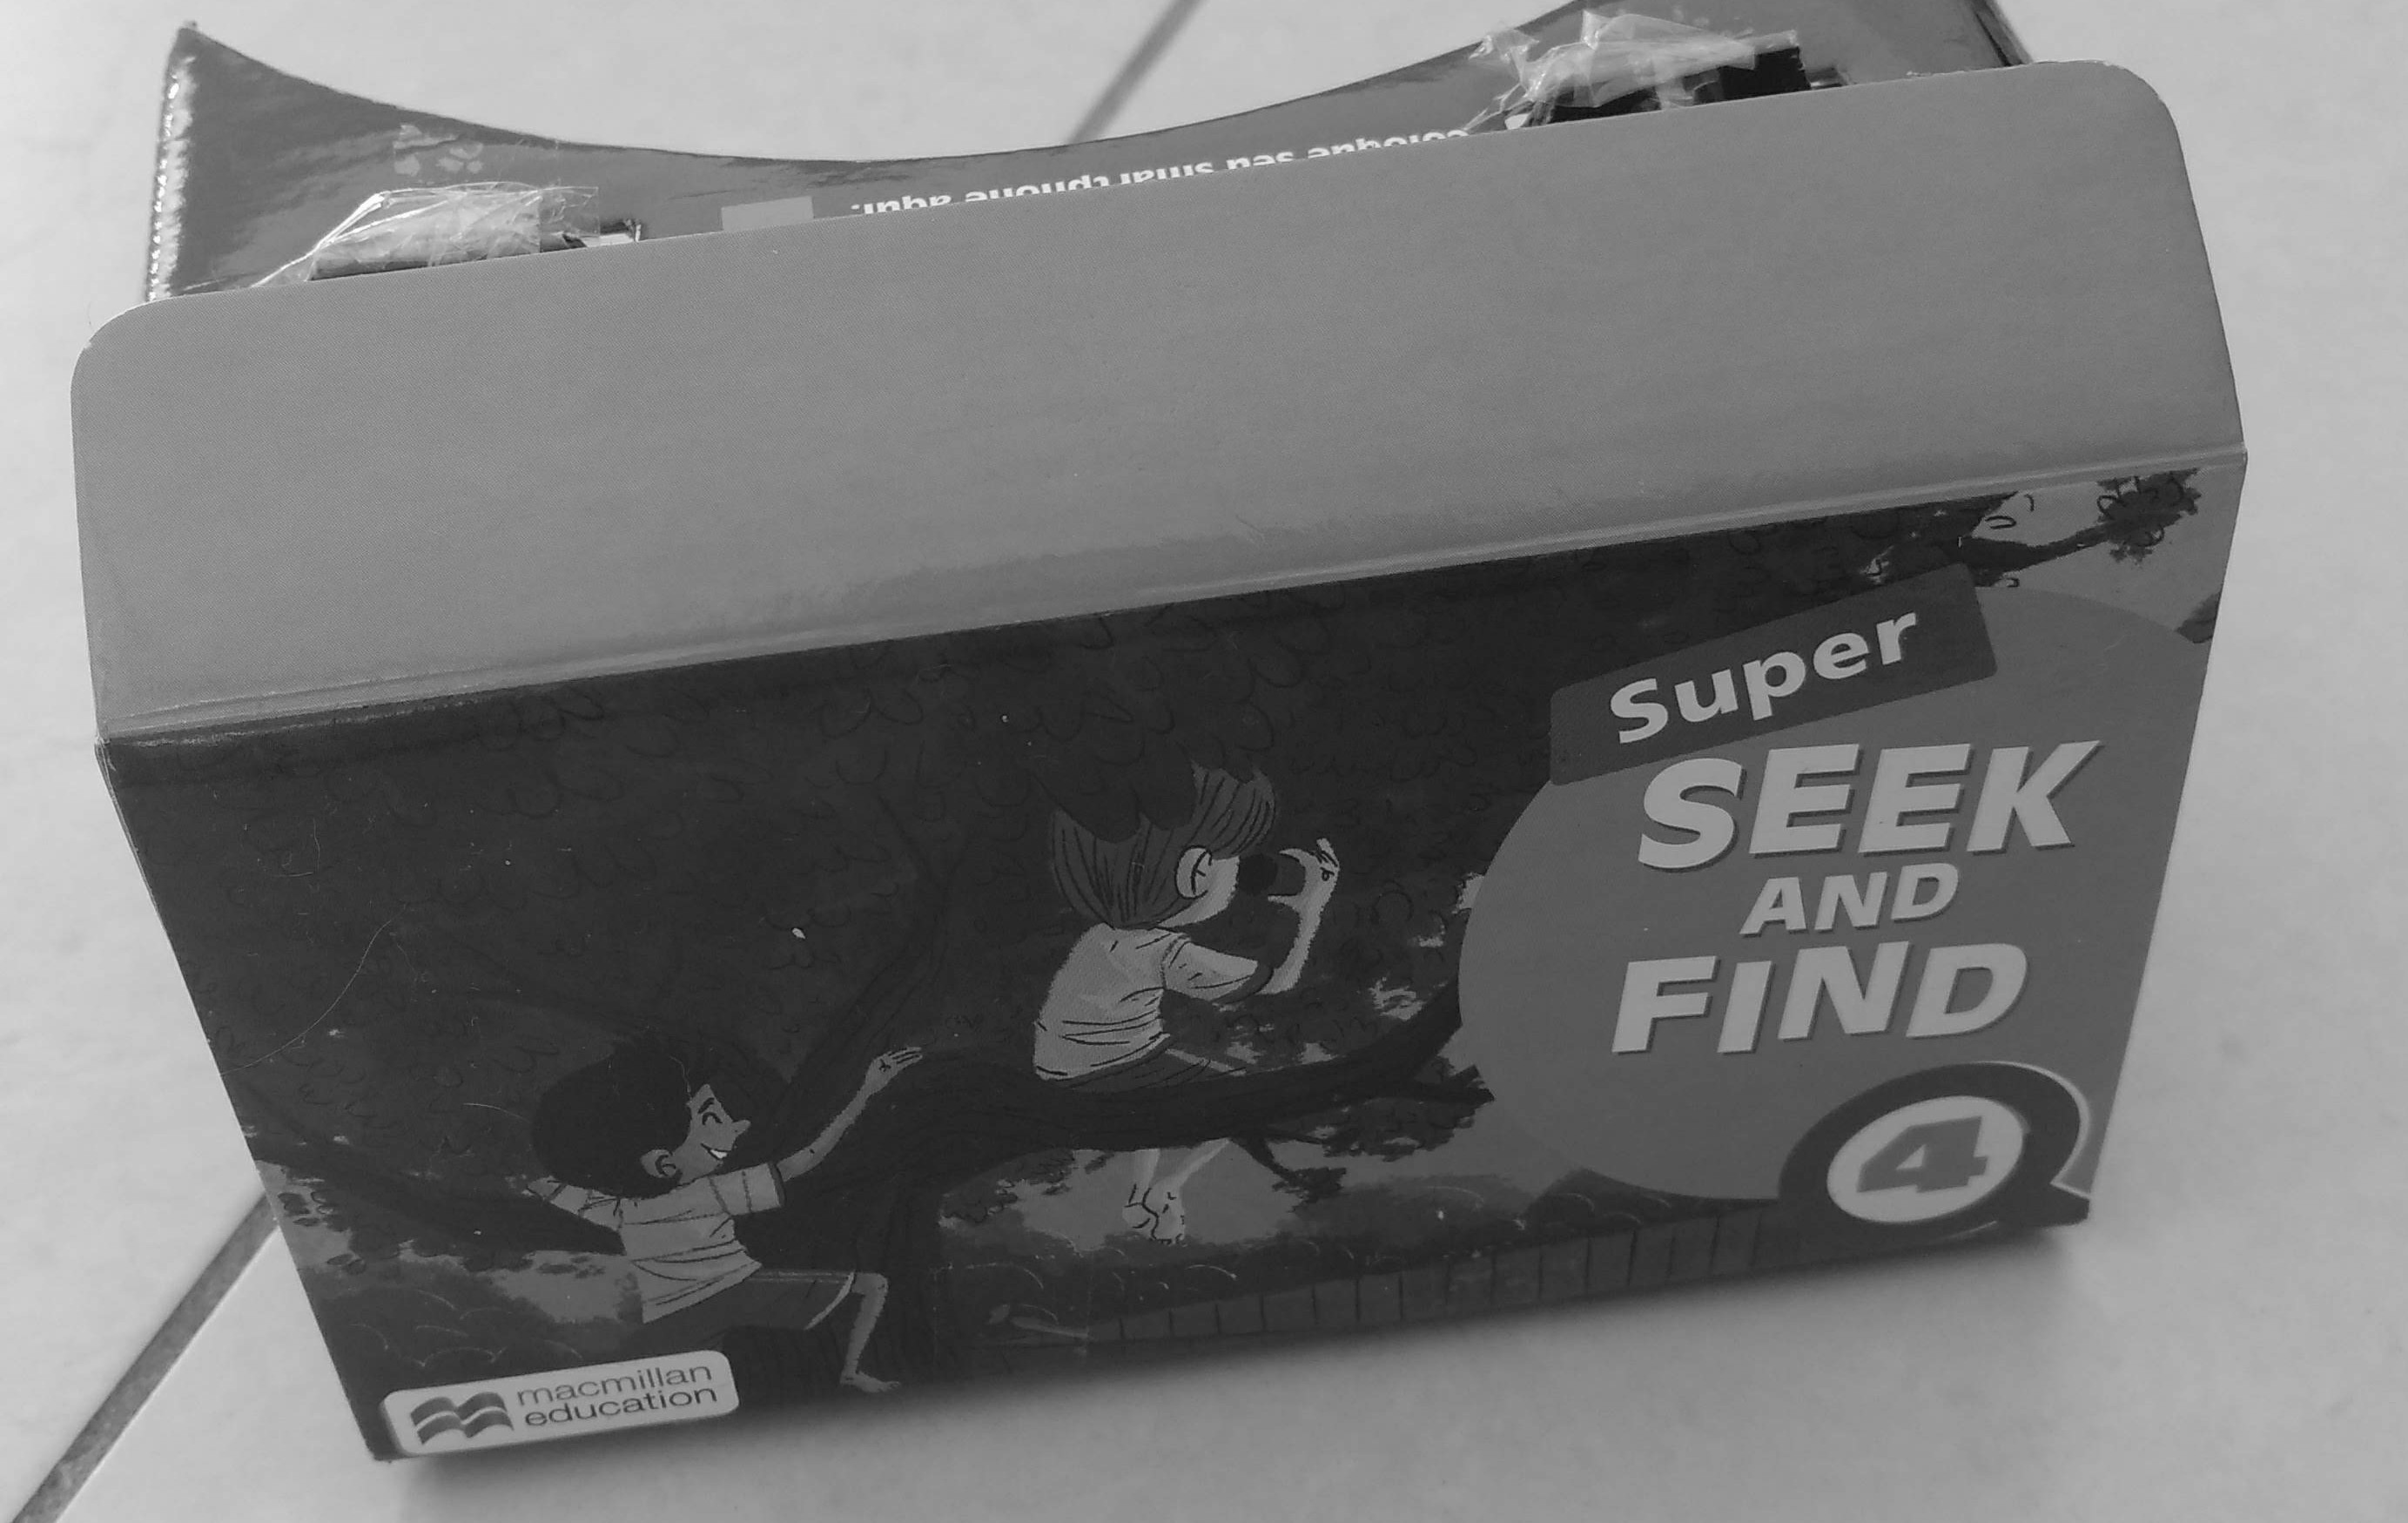

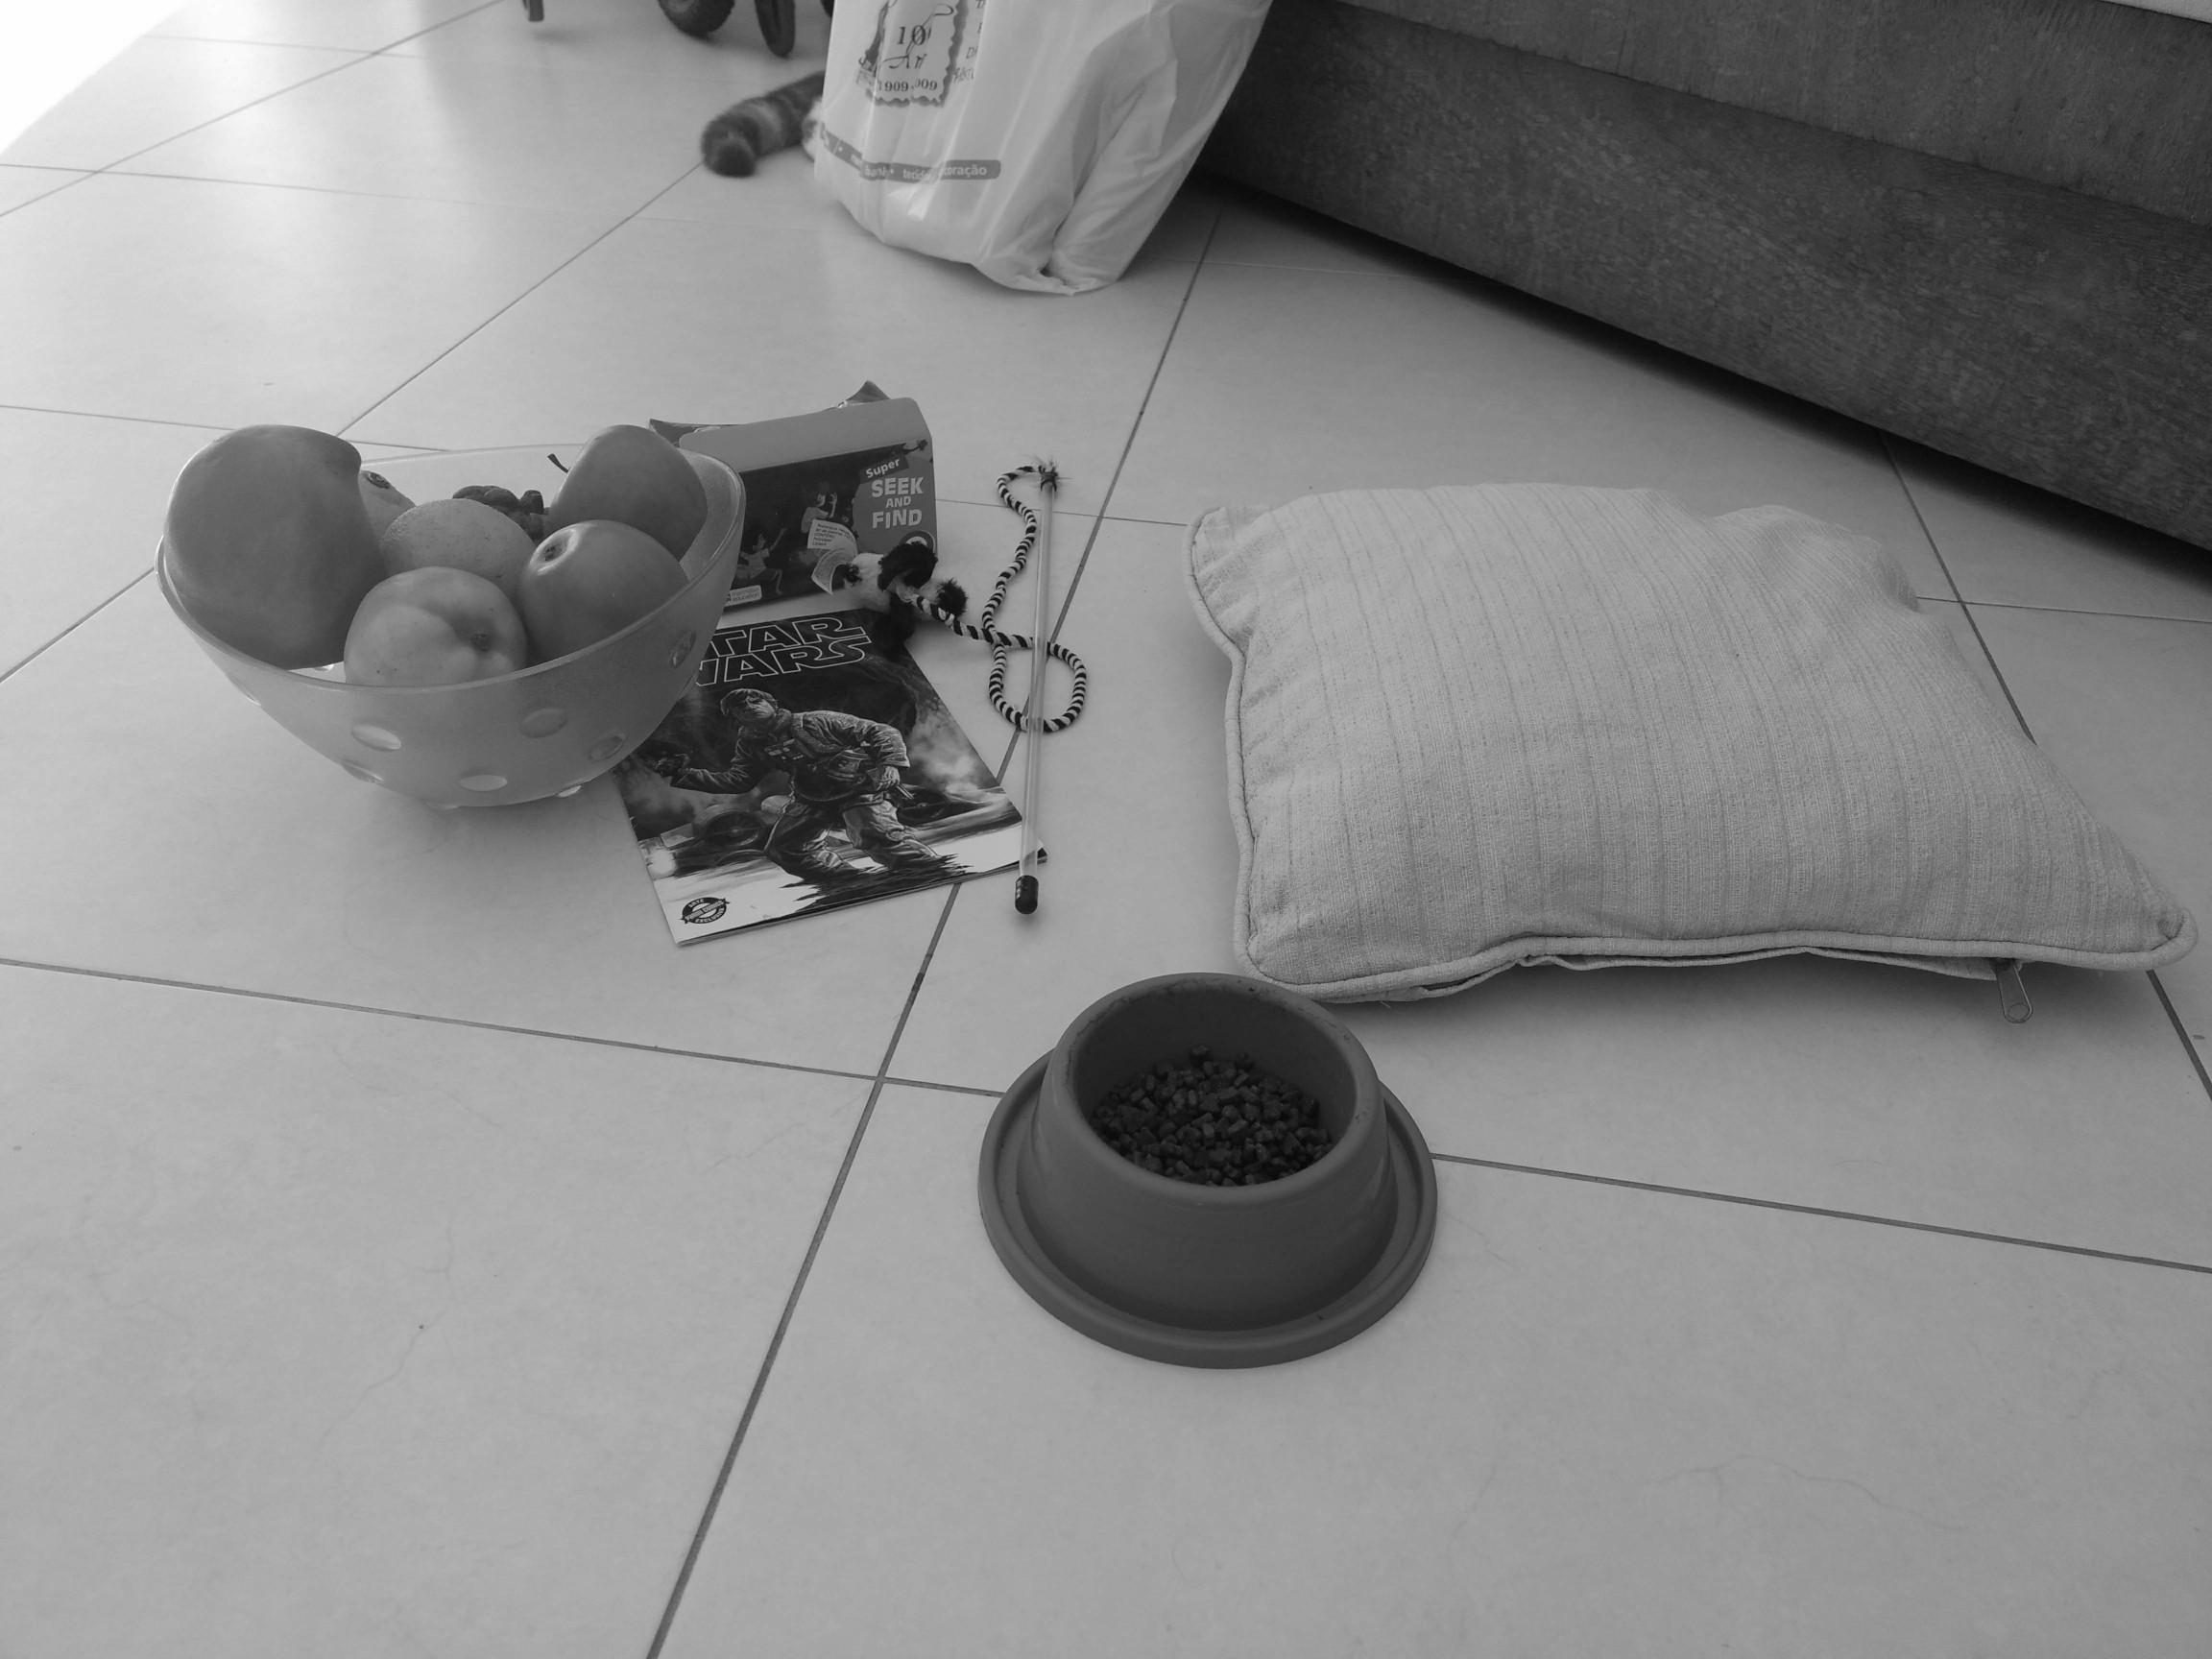

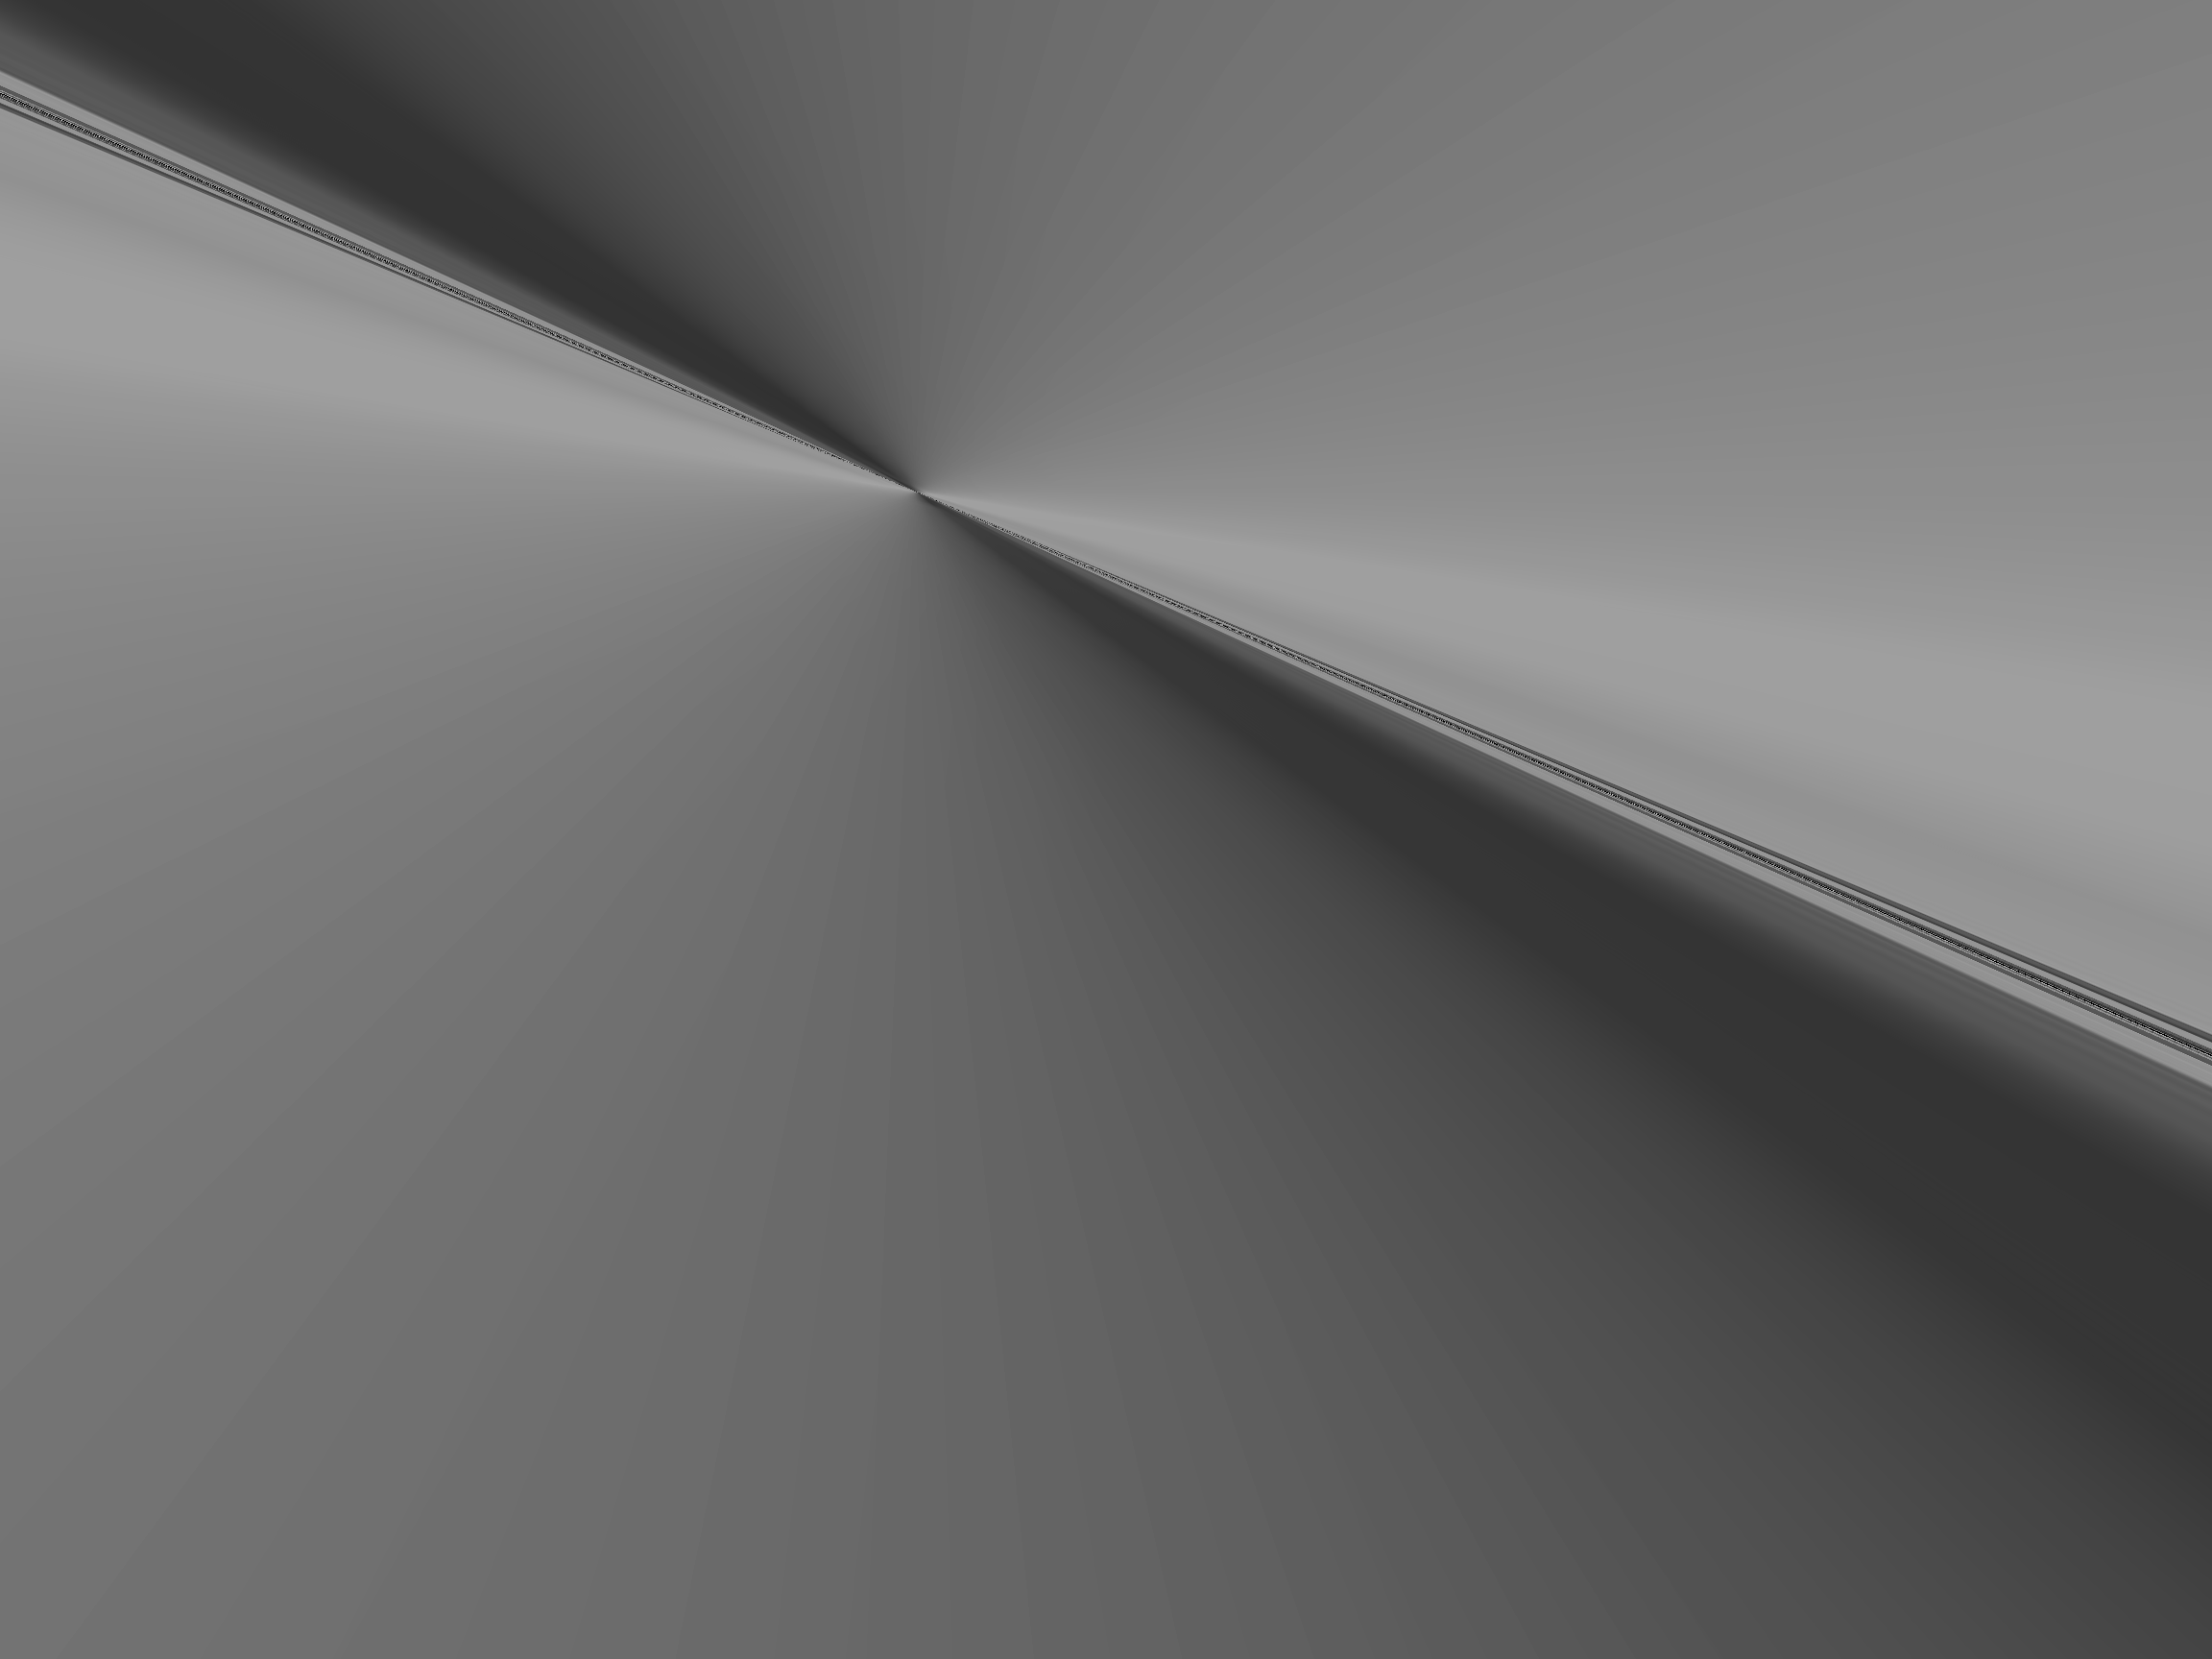

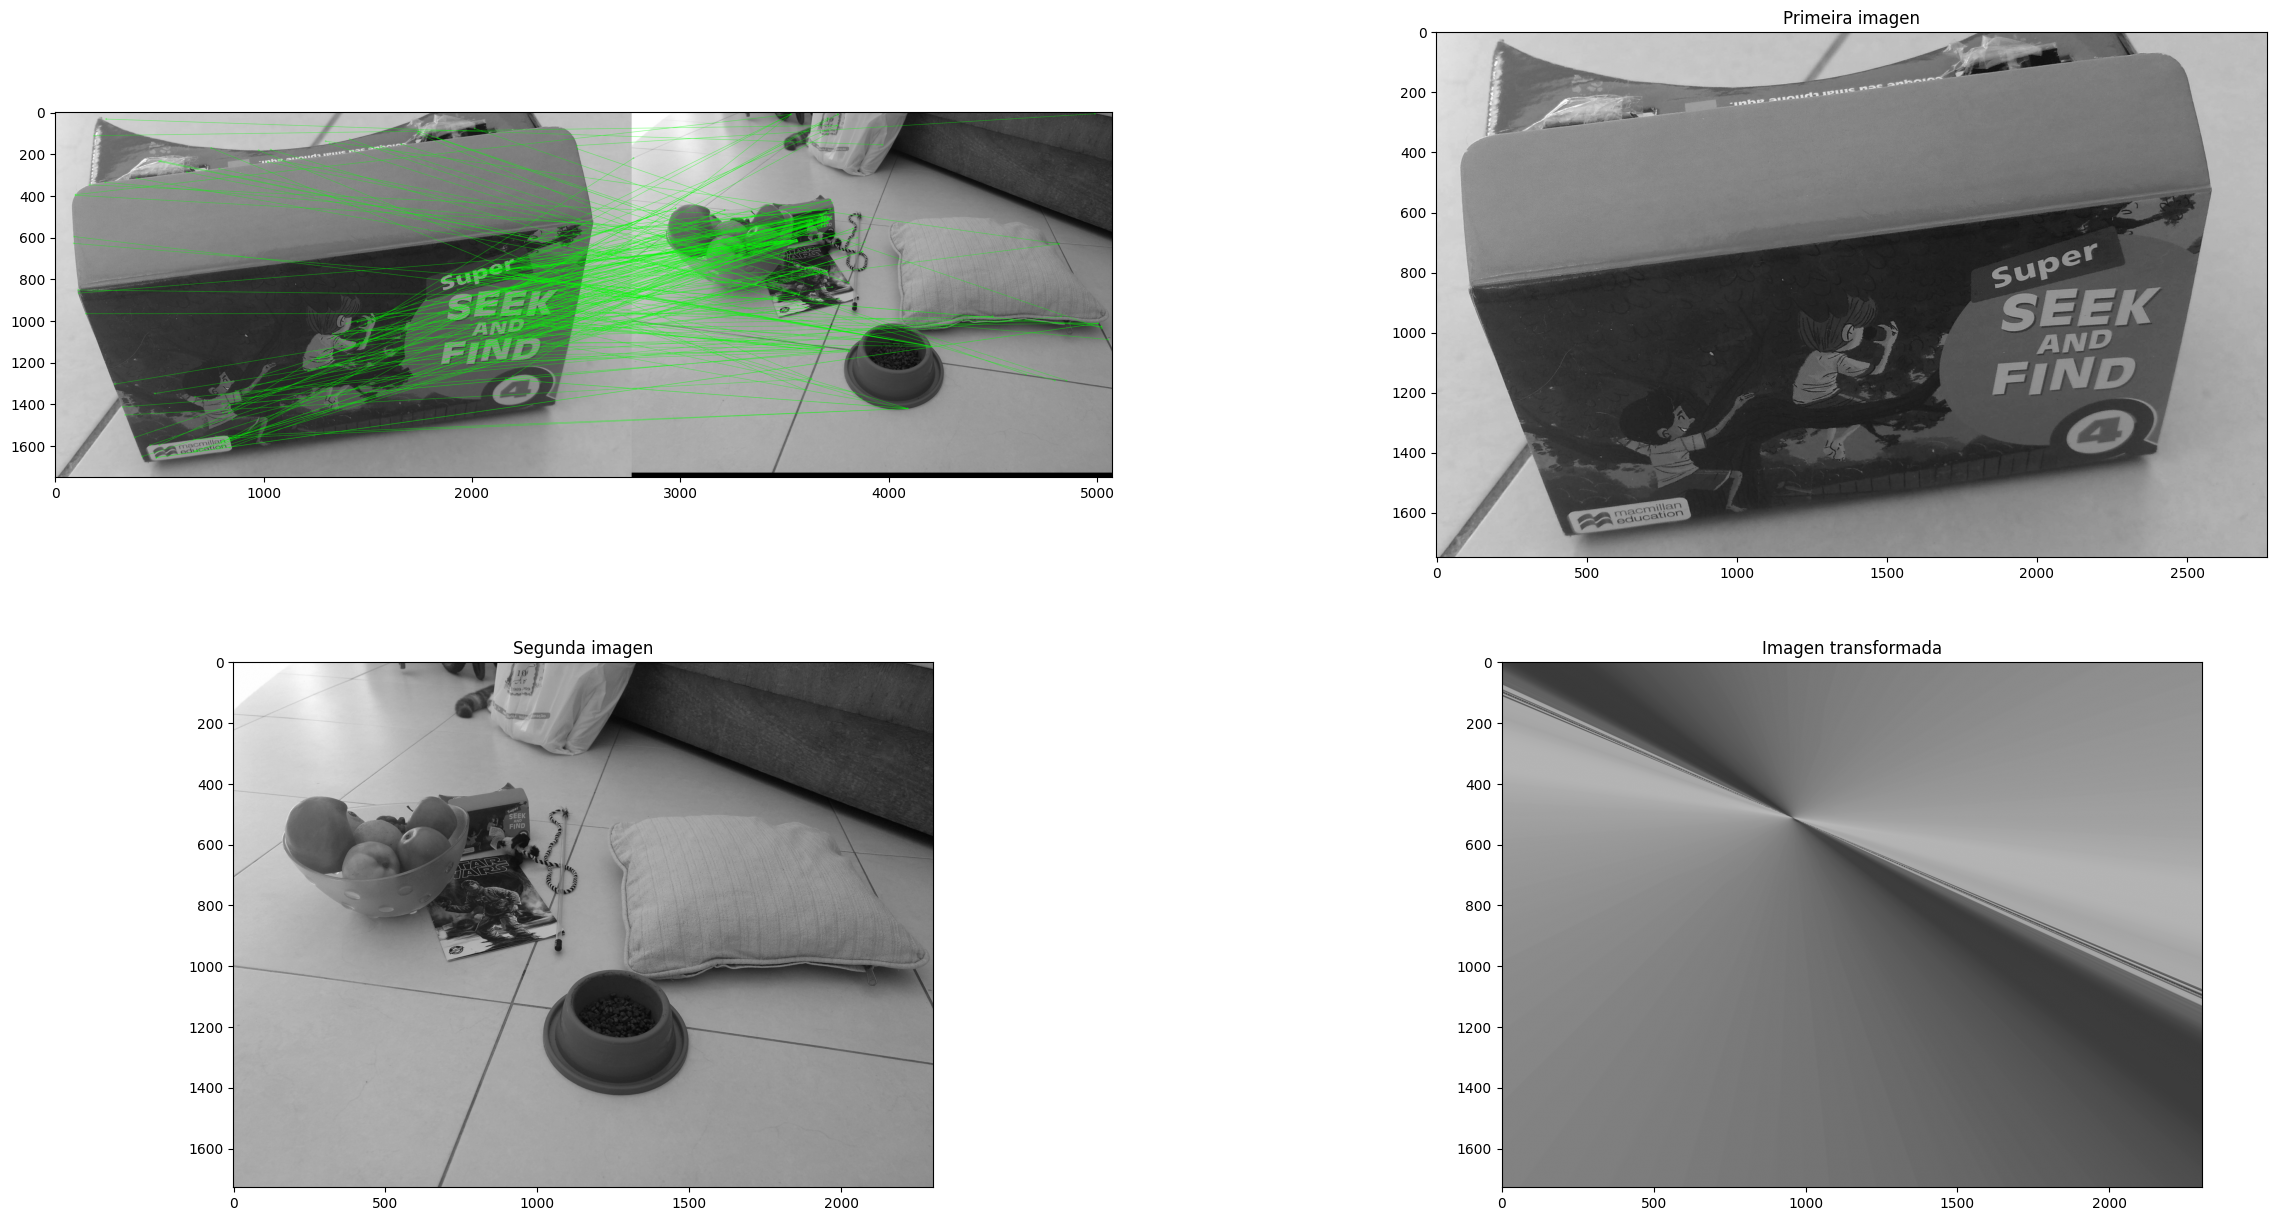

In [ ]:
# TRABALHO 2 DE VISÃO COMPUTACIONAL
# Nome: Javier Antonio Vargas Rivadineira
#       Diego Abraham Apaza

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow


def normalize_points(points):
    mean = np.mean(points, axis=0)
    std_dev = np.std(points, axis=0)
    std_dev[std_dev == 0] = 1e-8  # Evita división por cero
    scale = np.sqrt(2) / std_dev
    T = np.array([[scale[0], 0, -scale[0] * mean[0]],
                  [0, scale[1], -scale[1] * mean[1]],
                  [0, 0, 1]])
    norm_points = np.dot(T, np.vstack((points.T, np.ones(points.shape[0]))))
    return norm_points[:2].T, T

def compute_A(pts1, pts2):
    A = []
    for (x1, y1), (x2, y2) in zip(pts1, pts2):
        A.append([-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2])
        A.append([0, 0, 0, -x1, -y1, -1, x1*y2, y1*y2, y2])
    return np.array(A)

def compute_normalized_dlt(pts1, pts2):
    pts1_norm, T1 = normalize_points(pts1)
    pts2_norm, T2 = normalize_points(pts2)
    A = compute_A(pts1_norm, pts2_norm)
    U, S, Vt = np.linalg.svd(A)
    H_normalized = Vt[-1].reshape(3, 3)
    H = np.dot(np.linalg.inv(T2), np.dot(H_normalized, T1))
    return H / H[2, 2]


def RANSAC(pts1, pts2, dis_threshold=5, p=0.99, min_inliers=4):
    max_inliers = 0
    best_H = None
    best_inliers = np.array([])
    iteration = 0


    while True:  # El bucle ahora será infinito hasta que se estabilicen los inliers
        sample_indices = np.random.choice(len(pts1), 4, replace=False)
        sample_pts1, sample_pts2 = pts1[sample_indices], pts2[sample_indices]

        # Verificar si hay puntos duplicados y eliminarlos
        unique_pts1, unique_indices = np.unique(sample_pts1, axis=0, return_index=True)
        unique_pts2 = sample_pts2[unique_indices]

        if len(unique_pts1) < 4:
            continue  # Ignorar iteración si hay menos de 4 puntos únicos

        H = compute_normalized_dlt(unique_pts1, unique_pts2)
        transformed_pts1 = cv.perspectiveTransform(pts1.reshape(-1, 1, 2), H).reshape(-1, 2)
        distances = np.linalg.norm(transformed_pts1 - pts2, axis=1)
        inliers = np.where(distances < dis_threshold)[0]

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_inliers = inliers

        # Si los inliers no aumentan significativamente, romper el bucle
        if len(inliers) > min_inliers and len(inliers) == max_inliers:
            break  # Salir del bucle si ya no hay un aumento en los inliers

        iteration += 1

    print(f"Numero final de iteraciones ejecutadas: {iteration}")
    print(f"Número máximo de inliers encontrados: {max_inliers}")

    # Calcular la homografía con todos los inliers encontrados
    if max_inliers >= min_inliers:
        best_H = compute_normalized_dlt(pts1[best_inliers], pts2[best_inliers])

    return best_H, pts1[best_inliers], pts2[best_inliers]
# Cargar imágenes
img1 = cv.imread('box.jpg', 0)   # queryImage
img2 = cv.imread('photo01a.jpg', 0)  # trainImage

if img1 is None or img2 is None:
    print("Error: Imagens não carregadas.")
    exit()

# Inicialización de SIFT
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M, _, _ = RANSAC(src_pts.reshape(-1, 2), dst_pts.reshape(-1, 2))
    img4 = cv.warpPerspective(img1, M, (img2.shape[1], img2.shape[0]))

    # Mostrar imágenes con OpenCV en Colab
    cv2_imshow(img1)
    cv2_imshow(img2)
    cv2_imshow(img4)

    # Mostrar imágenes con Matplotlib
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))
    axs[0, 0].imshow(cv.drawMatches(img1, kp1, img2, kp2, good, None, matchColor=(0,255,0), singlePointColor=None, flags=2), 'gray')
    axs[0, 1].imshow(img1, 'gray')
    axs[0, 1].set_title('Primeira imagen')
    axs[1, 0].imshow(img2, 'gray')
    axs[1, 0].set_title('Segunda imagen')
    axs[1, 1].imshow(img4, 'gray')
    axs[1, 1].set_title('Imagen transformada')
    plt.show()
else:
    print(f"Sem suficientes coincidencias - {len(good)}/{MIN_MATCH_COUNT}")
